### Klasy bazowe

In [1]:
import abc

import tensorflow as tf

import tensorflow_addons as tfa

import numpy as np

class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer."""
        pass


class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def fit(self, **kwargs):
        """Fits the model.

        Replaces original fit method.
        
        More information can be found in documentation:
        https://www.tensorflow.org/guide/eager
        https://www.tensorflow.org/guide/autodiff
        """
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts x"""
        pass

### Instrukcje pomoniczne do wykonania przetwarzania wstępnego


In [2]:
import pickle

# Wczytanie zbioru danych
dataset_path = 'dataset.pkl'

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)

def load_x_y(ds_type):
    images = dataset[ds_type]['X']
    labels = dataset[ds_type]['y']
    return images, labels

# Ustawienie ziarna
tf.random.set_seed(1234)
def data_preprocessing(images, labels):
    # Zmiana rozmiaru obrazu z 224x224 do 64x64
    images = tf.image.resize(
        images, [64, 64], 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
        preserve_aspect_ratio=False,
        name=None
    )
    # Spłaszczenie obrazu do jednego wymiaru (np. z 64x64x3 do 12288)
    images = tf.reshape(images, [images.shape[0],-1])
    # Zmiana typu obrazów z int na float i normalizacja wartości pikseli z przedziału 0-255 do przedziału 0-1
    images = tf.cast(images, tf.float32) / 255.0
    # Zmiana wymiarowości z [8870] na [8870, 1] w celu zastosowania `SparseCategoricalCrossentropy`
    labels = tf.reshape(labels, [-1, 1])
    
    return images, labels

# Do iterowania zbioru danych i podzielenia na paczki (ang. batch) można wykorzystać interfejs zdefiniowany w `tensorflow.data.Dataset`
def create_ds(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels)) 
    dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size=100)
    return dataset



In [3]:
images_train, labels_train = load_x_y('train')
images_train, labels_train = data_preprocessing(images_train, labels_train)
train_ds = create_ds(images_train, labels_train)

images_test_before, labels_test = load_x_y('test')
images_test, labels_test = data_preprocessing(images_test_before, labels_test)
test_ds = create_ds(images_test, labels_test)

images_val, labels_val = load_x_y('validation')
images_val, labels_val = data_preprocessing(images_val, labels_val)
val_ds = create_ds(images_val, labels_val)



### Rozwiązanie

In [4]:
class BaseLayer(AbstractLayer):

    def __init__(self, activation_function, input_dim, units):
        super(BaseLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_uniform")
        self.b = self.add_weight(shape=(units,), initializer="random_uniform")
        self.activation_function = activation_function
        self.units = units
        
    def call(self, inputs):
        return self.activation_function(tf.matmul(inputs, self.w) + self.b)

class BaseModel(AbstractModel):
    
    def __init__(self): 
        super(BaseModel, self).__init__()
        self.l_1 = BaseLayer(activation_function = tf.keras.activations.relu, input_dim = 12288, units = 256)
        self.l_2 = BaseLayer(activation_function = tf.keras.activations.softmax, input_dim = 256, units = 14)

    def call(self, inputs, training=False):
        inputs_2 = self.l_1(inputs)
        return self.l_2(inputs_2)
        

    def fit(self, **kwargs):
        self.epoch_loss_train = []
        self.epoch_f1_train = []
        self.epoch_loss_val = []
        self.epoch_f1_val = []
        train_ds = kwargs.get("train_ds", None)
        batch_size = kwargs.get("batch_size", 100)
        lr = kwargs.get("lr", 0.001)
        epoch_num = kwargs.get("epoch_num", 25)
        optimizer = kwargs.get("optimizer", tf.keras.optimizers.Adam(learning_rate=lr))
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())
        val_ds = kwargs.get("val_ds", None)
        for epoch in range(epoch_num):
            print("\nStart of epoch %d" % (epoch,))
            f1_train = tfa.metrics.F1Score(num_classes=14, average="macro")
            f1_val = tfa.metrics.F1Score(num_classes=14, average="macro")
            #TRAIN
            for x, y in train_ds:
                with tf.GradientTape() as tape:
                    logits = self.call(x)
                    loss = cost_func(y, logits)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
                f1_train.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                   tf.one_hot(tf.argmax(logits, axis=-1), 
                                    depth=14))
            self.epoch_loss_train.append(loss)
            self.epoch_f1_train.append(f1_train.result())
            #VALIDATION
            for x, y in val_ds:
                logits = self.call(x)
                loss = cost_func(y, logits)
                f1_val.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                   tf.one_hot(tf.argmax(logits, axis=-1), 
                                    depth=14))
                
            self.epoch_loss_val.append(loss)
            self.epoch_f1_val.append(f1_val.result())
            print("TRAIN: Loss ={:.3f}, F1 ={:.3f}".format(self.epoch_loss_train[-1],self.epoch_f1_train[-1]))
            print("VALIDATION: Loss ={:.3f}, F1 ={:.3f}".format(self.epoch_loss_val[-1],self.epoch_f1_val[-1]))
    

    def predict(self, x):
        logits = model(x)
        return logits

In [6]:
model = BaseModel()

model.fit(train_ds = train_ds, val_ds = val_ds)


Start of epoch 0
TRAIN: Loss =2.527, F1 =0.040
VALIDATION: Loss =2.453, F1 =0.024

Start of epoch 1
TRAIN: Loss =2.566, F1 =0.050
VALIDATION: Loss =2.512, F1 =0.050

Start of epoch 2
TRAIN: Loss =2.445, F1 =0.081
VALIDATION: Loss =2.414, F1 =0.080

Start of epoch 3
TRAIN: Loss =2.577, F1 =0.090
VALIDATION: Loss =2.361, F1 =0.096

Start of epoch 4
TRAIN: Loss =2.410, F1 =0.099
VALIDATION: Loss =2.216, F1 =0.102

Start of epoch 5
TRAIN: Loss =2.428, F1 =0.108
VALIDATION: Loss =2.402, F1 =0.105

Start of epoch 6
TRAIN: Loss =2.424, F1 =0.114
VALIDATION: Loss =2.506, F1 =0.083

Start of epoch 7
TRAIN: Loss =2.392, F1 =0.118
VALIDATION: Loss =2.440, F1 =0.111

Start of epoch 8
TRAIN: Loss =2.376, F1 =0.118
VALIDATION: Loss =2.645, F1 =0.103

Start of epoch 9
TRAIN: Loss =2.191, F1 =0.126
VALIDATION: Loss =2.440, F1 =0.102

Start of epoch 10
TRAIN: Loss =2.435, F1 =0.125
VALIDATION: Loss =2.250, F1 =0.110

Start of epoch 11
TRAIN: Loss =2.493, F1 =0.127
VALIDATION: Loss =2.329, F1 =0.106

S

Text(0, 0.5, 'Loss')

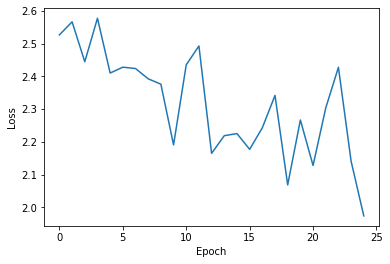

In [8]:
import matplotlib.pyplot as plt
plt.plot(model.epoch_loss_train)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

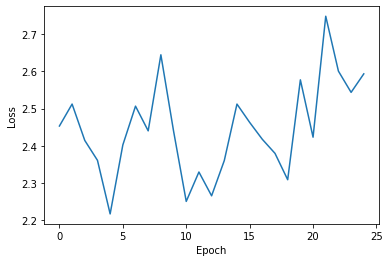

In [9]:
plt.plot(model.epoch_loss_val)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'F1 Score')

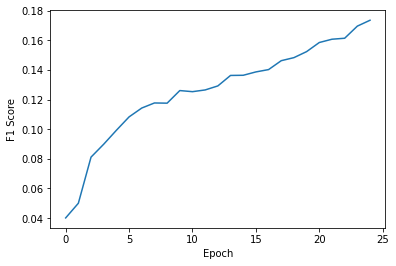

In [10]:
import matplotlib.pyplot as plt
plt.plot(model.epoch_f1_train)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

Text(0, 0.5, 'F1 Score')

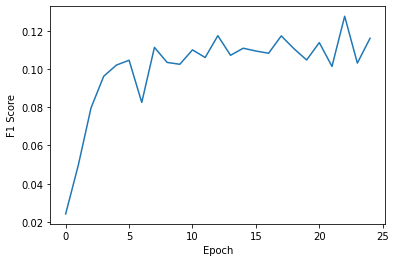

In [11]:
plt.plot(model.epoch_f1_val)
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

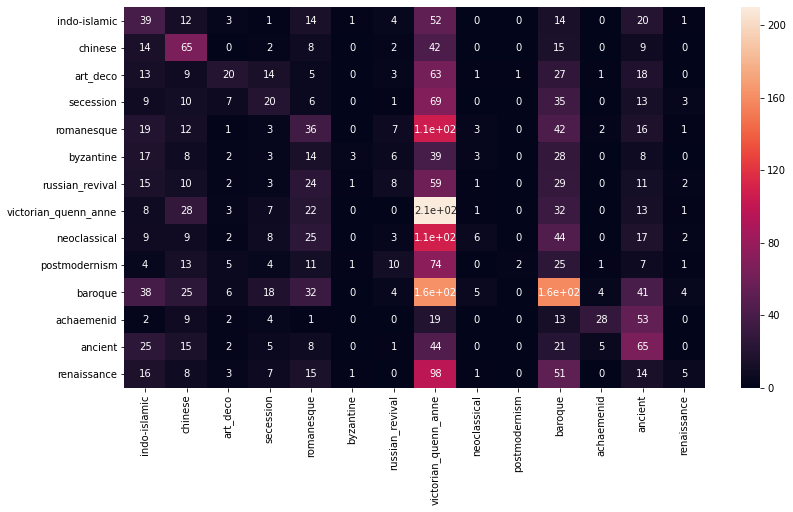

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
import pandas as pd
#Confiuson matrix
labels = list(dataset['labels_mapping'].keys())
y_pred = model.predict(images_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = labels_test
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (13,7))
sn.heatmap(df_cm, annot=True)

In [13]:
def show_image(image, correct, predicted):
    plt.imshow(image)
    plt.title(f'Correct: {correct} Predicted: {predicted}')
    plt.show()

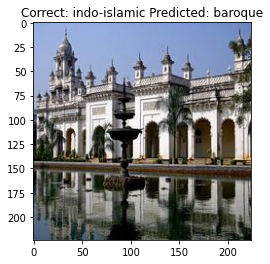

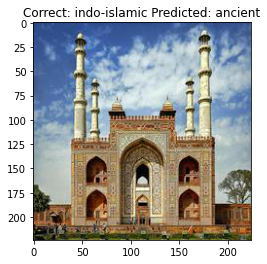

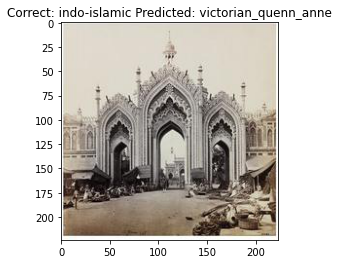

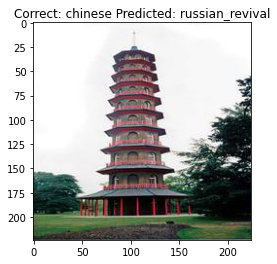

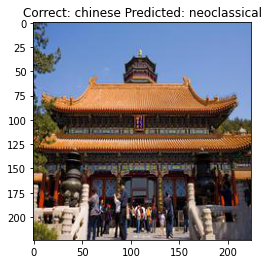

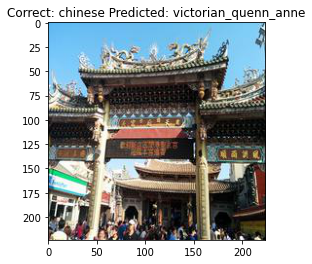

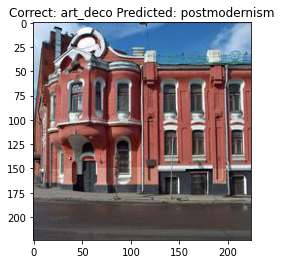

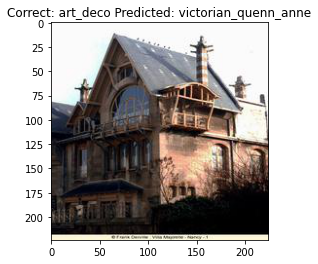

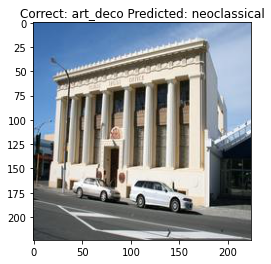

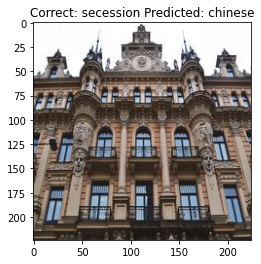

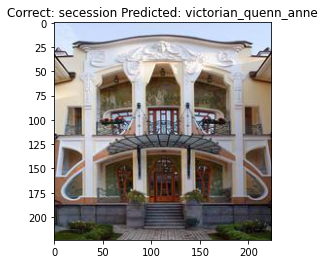

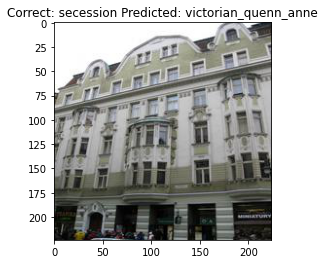

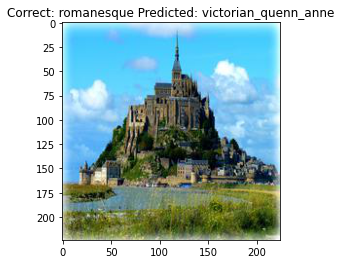

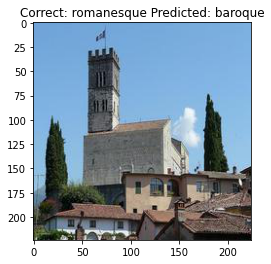

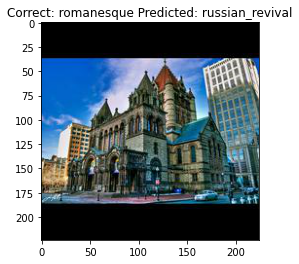

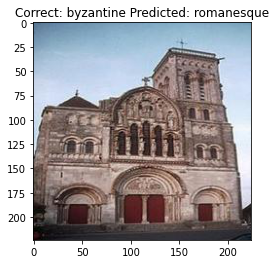

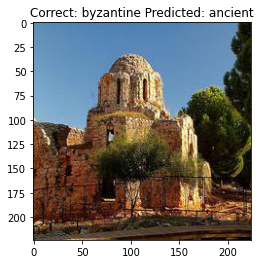

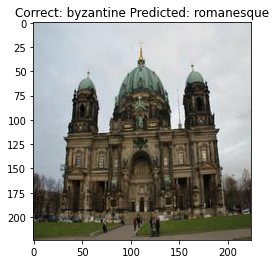

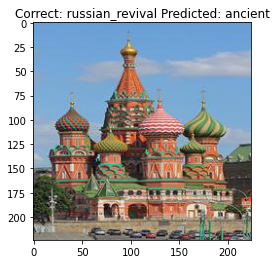

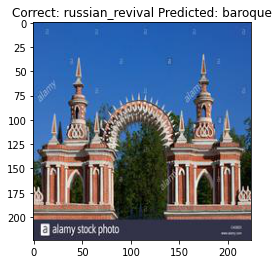

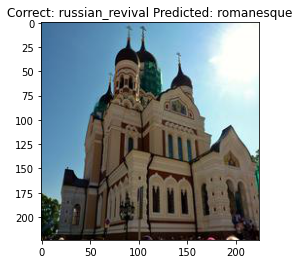

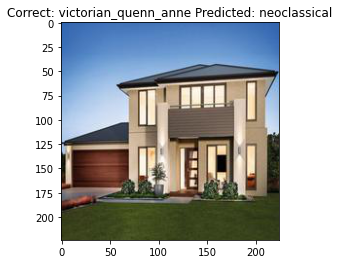

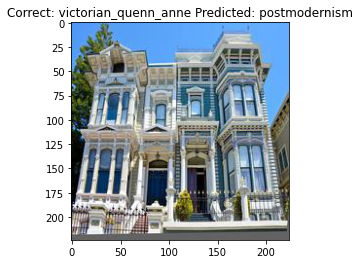

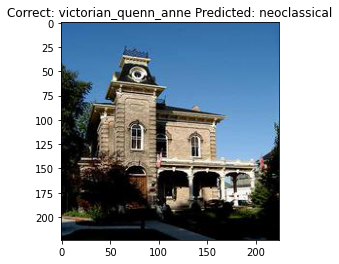

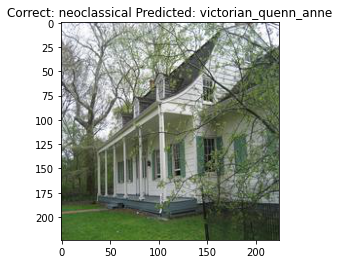

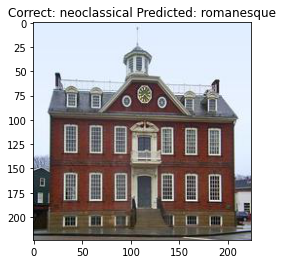

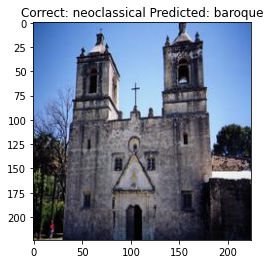

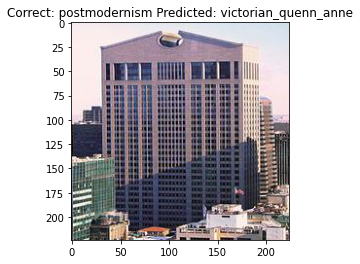

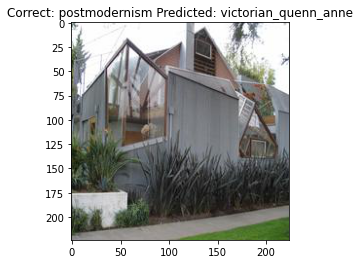

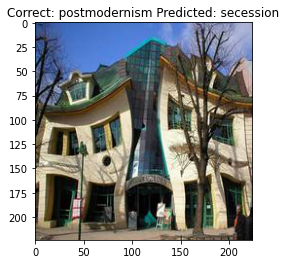

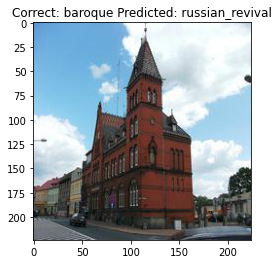

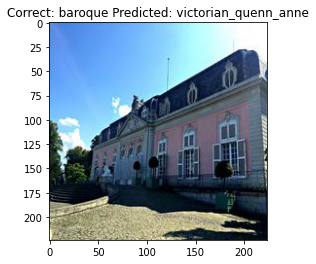

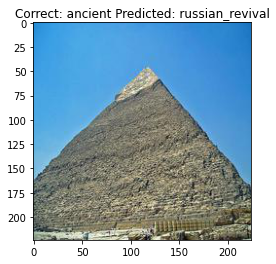

In [14]:
y_pred = model.predict(images_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = labels_test
labels = list(dataset['labels_mapping'].keys())
for c in range(14):
    count = 0
    for x, y_p, y_t in zip(images_test_before, y_pred, y_true):
        y_t = y_t.numpy()[0]
        if y_t == c:
            if (y_p != y_t) and count<3:
                count +=1
                show_image(x,labels[y_t],labels[y_p])
                

### Podsumowanie
Sieć uczy się rozpoznawać style architektoniczne o czym świadczy rosnąca tendencja F1. 
Wyniki są bardzo przeciętne. Wartość metryki F1 na zbiorze walidacyjnym to ok. 20 %. 
Architektura sieci jest zbyt prosta by poradzić sobie z zadaniem rozpoznawania stylu. 
Najbardziej problematycznym stylem w klasyfikacji jest barok - macierz pomyłek.
Źle zaklasyfikowane przykłady mogą zawierać elementy innego stylu.